Maciej Kobiela, 19.01.2025

# Model machine learningowy do przewidwania porowatości materiału

Program ma na podstawie danego arkusza kalkualcyjnego wytrenować model machine learningowy i przewidzieć z jak największą dokładnością dany parametr, który jest podany w arkuszu.

Pakietamy używanymi przez nas będzie biblioteka `pandas`, moduł `pyplot` biblioteki `matplotlib`, `xgboost` (nasz model machine learningowy) i  moduły `model_selection` i `mean_squared_error` z bibloteki `sklearn`.

In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Wczytamy arkusz z danymi jako `df`:

In [111]:
df = pd.read_excel('./../3D_ML.xlsx')
df

,Moc,Prędkość skanowania,grubość wartswy,porowatosc
0,200,1300,100,2.31
1,240,1100,90,2.44
2,240,1200,70,2.55
3,200,1100,90,2.68
4,200,1100,100,2.68
...,...,...,...,...
94,200,1300,100,3.83
95,280,900,110,3.83
96,200,1300,90,3.84
97,240,1200,80,3.85


 Jak widać, będziemy zadawać się tylko z floatami i integerami, więc nie będzie potrzeby konwertować danych na inne struktury.

Rozdzielmy więc dane na części. `X` będzie obiektem danych, między którymi model będzie starał się znaleźć zależność taką, aby z jak największą dokładnością przewidywać obiekt danych `Y`:

In [112]:
X = df[['Moc', 'Prędkość skanowania', 'grubość wartswy']]
y = df['porowatosc']
X

,Moc,Prędkość skanowania,grubość wartswy
0,200,1300,100
1,240,1100,90
2,240,1200,70
3,200,1100,90
4,200,1100,100
...,...,...,...
94,200,1300,100
95,280,900,110
96,200,1300,90
97,240,1200,80


Teraz możemy stworzyć dane treningowe i testowe dla naszego modelu przy użyciu metody `train_test_split`. Damy tej metodzie takie parametry, aby przewidziała ostatnie 20% arkusza za pomocą pierwszych 80% danych treningowych:

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_test

,Moc,Prędkość skanowania,grubość wartswy
26,200,1100,110
86,280,900,90
2,240,1200,70
55,200,1200,100
75,280,800,60
92,200,1200,80
16,240,1200,70
73,200,1200,110
54,200,1100,100
94,200,1300,100


Z tymi danymi możemy napisać nasz model i za jego pomocą przewidzieć wartości `Y`:

In [114]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.4, max_depth=10, random_state=0)
reg.fit(X_train, y_train)
predictions = reg.predict(X_test)
predictions

array([3.1926987, 3.4817908, 3.6309466, 3.639951 , 3.6810071, 3.2649133,
       3.6309466, 3.7627842, 3.0936317, 3.3329818, 3.146292 , 3.222542 ,
       3.6480768, 3.4525778, 3.3783028, 3.1926987, 3.5789971, 3.7627842,
       3.2879755, 3.639951 ], dtype=float32)

Skopiujmy dane `Y` i zamieńmy ostatnie 20 pozycji na nasze nowe, "przewidziane" dane:

In [115]:
y_pred = y.copy()
y_pred.iloc[-20:] = predictions[:20]

Sprawdźmy teraz wyniki naszego modelu:

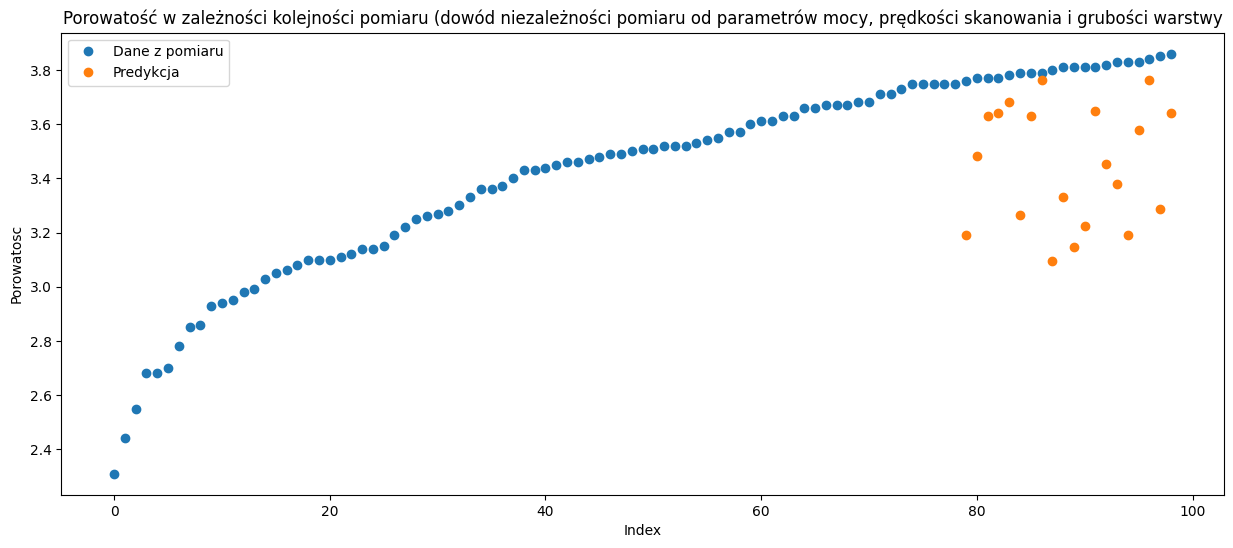

In [116]:
plt.figure(figsize=(15,6))
plt.plot(df.index, df['porowatosc'], 'o', label='Dane z pomiaru')
plt.plot(df.index[-20:], y_pred.iloc[-20:], 'o', label='Predykcja')
plt.xlabel('Index')
plt.ylabel('Porowatosc')
plt.title('Porowatość w zależności kolejności pomiaru (dowód niezależności pomiaru od parametrów mocy, prędkości skanowania i grubości warstwy')
plt.legend()
plt.show()

Jak widać, przewidziane wartości znacznie odbiegają od poprawnych. Zaraz się przekonamy że model jednak zadziałał poprawnie, a tą rozbieżność można zobaczyć poprzez analize poszczególnych zależności.

Sprawdźmy, jaką ważność model przydzielił poszczególnym zmiennym. Stworzymy w tym celu nowy Dataframe, nazywając go `fi` i przydzielimy mu szczegóły wyników z naszego modelu `reg`:

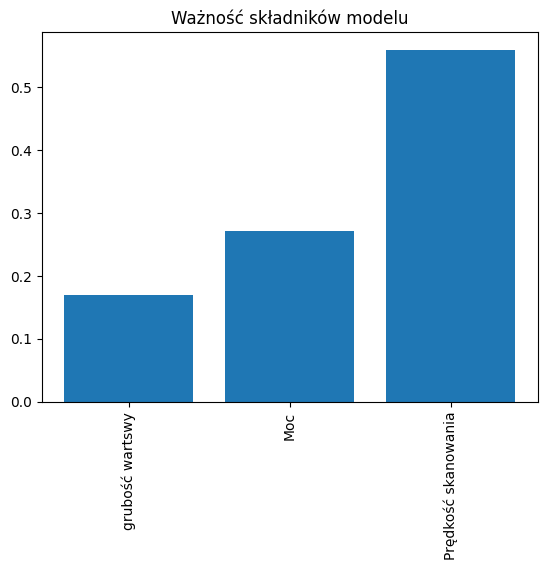

In [117]:
fi = pd.DataFrame()
fi['Składnik'] = reg.feature_names_in_
fi['Ważność'] = reg.feature_importances_
fi.sort_values('Ważność', inplace=True)
plt.bar(fi['Składnik'], height=fi['Ważność'])
plt.title('Ważność składników modelu')
plt.xticks(rotation=90)
plt.show()

Model zdecydowanie największą ważność przydzielił prędkości skanowania. Możemy w takim razie przeanalizować teraz grafy zależności porowatości od wszystkich trzech parametrów:

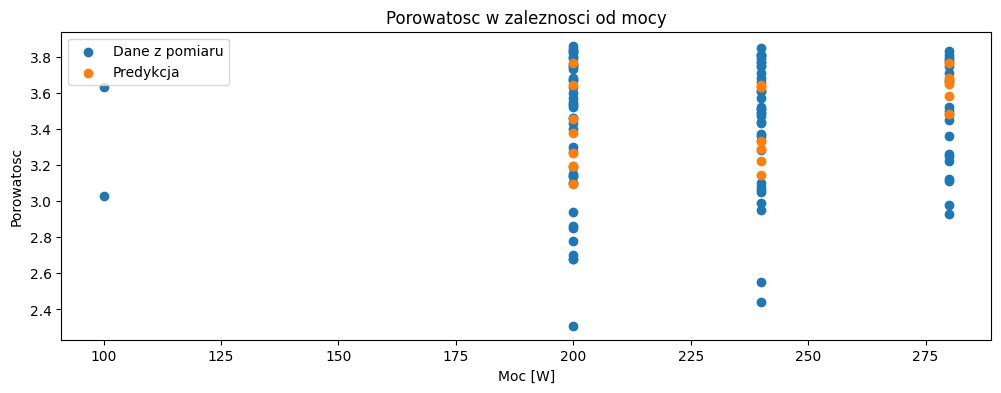

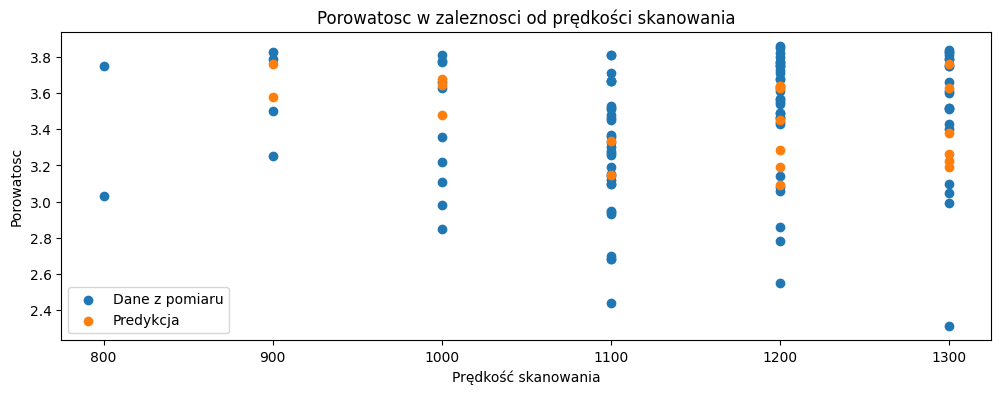

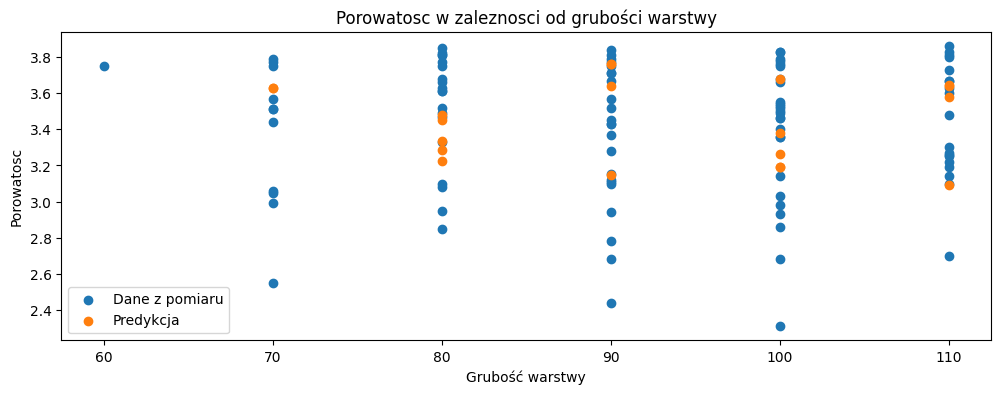

In [118]:
plt.figure(figsize=(12, 4))
plt.scatter(df['Moc'], df['porowatosc'], label='Dane z pomiaru')
plt.scatter(df['Moc'].iloc[-20:], y_pred.iloc[-20:], label='Predykcja')
plt.xlabel('Moc [W]')
plt.ylabel('Porowatosc')
plt.title('Porowatosc w zaleznosci od mocy')
plt.legend()
plt.show()
plt.figure(figsize=(12, 4))
plt.scatter(df['Prędkość skanowania'], df['porowatosc'], label='Dane z pomiaru')
plt.scatter(df['Prędkość skanowania'].iloc[-20:], y_pred.iloc[-20:], label='Predykcja')
plt.xlabel('Prędkość skanowania')
plt.ylabel('Porowatosc')
plt.title('Porowatosc w zaleznosci od prędkości skanowania')
plt.legend()
plt.show()
plt.figure(figsize=(12, 4))
plt.scatter(df['grubość wartswy'], df['porowatosc'], label='Dane z pomiaru')
plt.scatter(df['grubość wartswy'].iloc[-20:], y_pred.iloc[-20:], label='Predykcja')
plt.xlabel('Grubość warstwy')
plt.ylabel('Porowatosc')
plt.title('Porowatosc w zaleznosci od grubości warstwy')
plt.legend()
plt.show()

Te wykresy pokazują (i zarazem udowadniają) nieliniową zależność wszystkich trzech parametrów od porowatości. Na końcu możemy jeszcze sprawdzić średnie odchylenie od poprawnej wartości: 

In [124]:
mse = mean_squared_error(df['porowatosc'][79:], y_pred.iloc[-20:])
print('MSE:', mse)

MSE: 0.1734737510728643


# Ponieważ MSE = ~17.3%, możemy uznać, że nasz model w zadowalającym stopniu przewidział porowatość, pomimo braku czystej, liniowej zależności.